In [14]:
# import req libs
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.max_open_warning'] = 50  # Set the maximum number of open figures before warning

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Reshape,LeakyReLU,Dropout,Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, )
from tensorflow.keras.optimizers import Adam

In [15]:
root_img_path = r"D:\data\images\anime_faces"
BATCH_SIZE = 64
IM_SHAPE = (64,64,3)
LEARNING_RATE = 2e-4
LATENT_DIM=100
EPOCHS=20

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    root_img_path, 
    label_mode=None, 
    image_size=(IM_SHAPE[0], IM_SHAPE[1]), 
    batch_size=BATCH_SIZE
)

Found 641 files belonging to 1 classes.


In [16]:
dataset

<_BatchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

In [17]:
def preprocess(image):
    return tf.cast(image, tf.float32) / 127.5 - 1.0

In [18]:
train_dataset = (
    dataset
    .map(preprocess)
    .unbatch()
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(BATCH_SIZE,drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

In [19]:
for d in train_dataset.take(1):
    print(d.shape)

(64, 64, 64, 3)


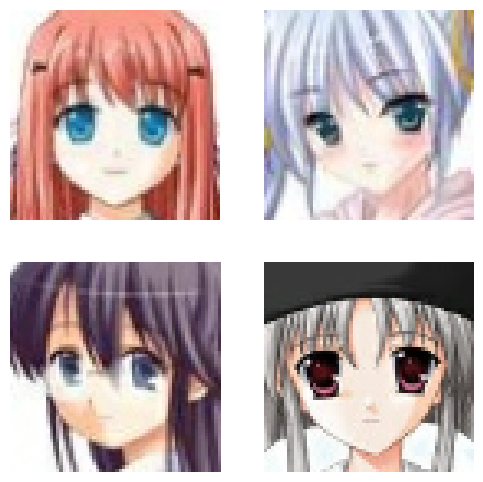

In [20]:
plt.figure(figsize = (6,6))
k=0
n = 4
for i in range(n):
    ax = plt.subplot(2,2, k+1)
    plt.imshow((d[i]+1)/2)
    plt.axis("off")
    k+=1

In [21]:
generator=tf.keras.Sequential([
  Input(shape=(LATENT_DIM,)),
  Dense(4*4*LATENT_DIM),
  Reshape((4,4,LATENT_DIM)),

  Conv2DTranspose(512,kernel_size=4,strides=2, padding='same'),
  BatchNormalization(),
  LeakyReLU(0.2),

  Conv2DTranspose(256,kernel_size=4,strides=2, padding='same'),
  BatchNormalization(),
  LeakyReLU(0.2),

  Conv2DTranspose(128,kernel_size=4,strides=2, padding='same'),
  BatchNormalization(),
  LeakyReLU(0.2),

  Conv2DTranspose(3,kernel_size=4,strides=2, activation=tf.keras.activations.tanh, padding='same'),

],name='generator')

generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1600)              161600    
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 100)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 8, 8, 512)        819712    
 ranspose)                                                       
                                                                 
 batch_normalization_5 (Batc  (None, 8, 8, 512)        2048      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 16, 16, 256)      20

In [22]:
discriminator=tf.keras.Sequential([
  Input(shape=(IM_SHAPE[0],IM_SHAPE[1],3)),

  Conv2D(64,kernel_size=4,strides=2, padding='same'),
  LeakyReLU(0.2),

  Conv2D(128,kernel_size=4,strides=2, padding='same'),
  BatchNormalization(),
  LeakyReLU(0.2),
  
  Conv2D(256,kernel_size=4,strides=2, padding='same'),
  BatchNormalization(),
  LeakyReLU(0.2),

  Conv2D(1,kernel_size=4,strides=2, padding='same'),

  Flatten(),
  Dense(1,activation='sigmoid')
  

],name='discriminator')

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_8 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 256)         524544    
                                                     

In [23]:
class ShowImage(tf.keras.callbacks.Callback):
    def __init__(self, latent_dim=100):
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        n=6
        k=0
        out=self.model.generator(tf.random.normal(shape=(36, self.latent_dim)))
        plt.figure(figsize=(16,16))
        for i in range(n):
            for j in range(n):
                ax=plt.subplot(n,n,k+1)
                plt.imshow((out[k]+1)/2,)
                plt.axis('off')
                k+=1
        plt.savefig("generated/gen_images_epoch_{}.png".format(epoch+1))
        plt.close()

In [24]:
class GAN(tf.keras.Model):
    
    def __init__(self,discriminator,generator):
        super(GAN,self).__init__()
        self.discriminator=discriminator
        self.generator=generator

    def compile(self,d_optimizer,g_optimizer,loss_fn):
        super(GAN,self).compile()
        self.d_optimizer=d_optimizer
        self.g_optimizer=g_optimizer
        self.loss_fn=loss_fn
        self.d_loss_metric=tf.keras.metrics.Mean(name='d_loss')
        self.g_loss_metric=tf.keras.metrics.Mean(name='g_loss')

    @property
    def metrics(self):
        return [self.d_loss_metric,self.g_loss_metric]

    def train_step(self,real_images):
        
        batch_size=tf.shape(real_images)[0]

        ######## Discriminator
        random_noise=tf.random.normal(shape=(batch_size,LATENT_DIM))
        fake_images=self.generator(random_noise)

        real_labels=tf.ones((batch_size,1))+0.25*tf.random.uniform((batch_size,1),minval=-1,maxval=1)
        fake_labels=tf.zeros((batch_size,1))+0.25*tf.random.uniform((batch_size,1),)

        with tf.GradientTape() as recorder:
            real_predictions=self.discriminator(real_images)
            d_loss_real=self.loss_fn(real_labels,real_predictions)

            fake_predictions=self.discriminator(fake_images)
            d_loss_fake=self.loss_fn(fake_labels,fake_predictions)

            d_loss=d_loss_real+d_loss_fake

        partial_derivatives = recorder.gradient(d_loss,self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(partial_derivatives, self.discriminator.trainable_weights))

        ############# Generator
        random_noise=tf.random.normal(shape=(batch_size,LATENT_DIM))
        flipped_fake_labels=tf.ones((batch_size,1))

        with tf.GradientTape() as recorder:

            fake_predictions=self.discriminator(self.generator(random_noise))
            g_loss=self.loss_fn(flipped_fake_labels,fake_predictions)

        partial_derivatives = recorder.gradient(g_loss,self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(partial_derivatives, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {'d_loss':self.d_loss_metric.result(),
                'g_loss':self.g_loss_metric.result()}

In [25]:
gan=GAN(discriminator,generator)
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE,beta_1=0.5),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE,beta_1=0.5),
    loss_fn=tf.keras.losses.BinaryCrossentropy(),
)

In [26]:
EPOCHS=250
history=gan.fit(train_dataset.take(200),epochs=EPOCHS,callbacks=[ShowImage(LATENT_DIM)])

Epoch 1/250


10/10 [==============================] - 15s 1s/step - d_loss: 1.0434 - g_loss: 0.6335
Epoch 2/250
10/10 [==============================] - 12s 1s/step - d_loss: 0.6834 - g_loss: 0.9137
Epoch 3/250
10/10 [==============================] - 12s 1s/step - d_loss: 0.7166 - g_loss: 0.9968
Epoch 4/250
10/10 [==============================] - 12s 1s/step - d_loss: 0.5074 - g_loss: 1.2000
Epoch 5/250
10/10 [==============================] - 12s 1s/step - d_loss: 0.4478 - g_loss: 1.7076
Epoch 6/250
10/10 [==============================] - 13s 1s/step - d_loss: 0.6123 - g_loss: 2.4193
Epoch 7/250
10/10 [==============================] - 12s 1s/step - d_loss: 0.4229 - g_loss: 2.2786
Epoch 8/250
10/10 [==============================] - 12s 1s/step - d_loss: 0.5853 - g_loss: 2.7711
Epoch 9/250
10/10 [==============================] - 12s 1s/step - d_loss: 0.9275 - g_loss: 2.3034
Epoch 10/250
10/10 [==============================] - 12s 1s/step - d_loss: 0.7134 - g_loss: 1.9334
Epoch 11/250
10/10 [=

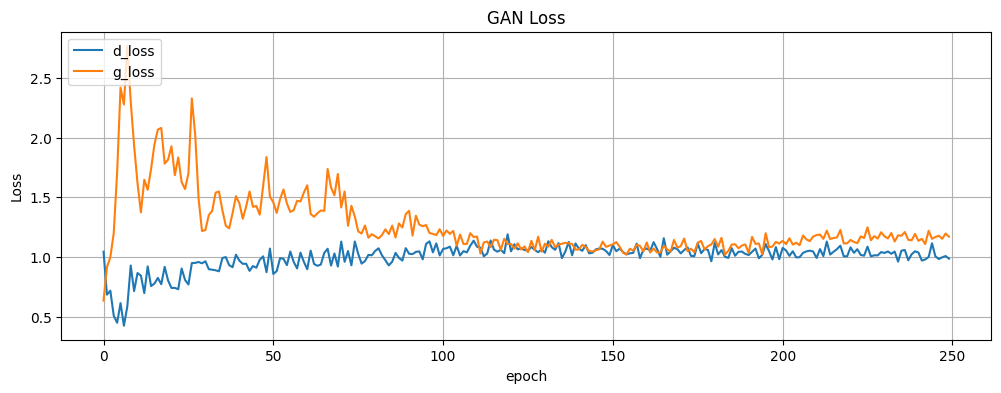

In [27]:
plt.figure(figsize=(12,4))
plt.plot(history.history['d_loss'])
plt.plot(history.history['g_loss'])
plt.title('GAN Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['d_loss', 'g_loss'], loc='upper left')
plt.grid(True)
plt.show()